# Predicting Uganda Treasury Bill Auction Yields 

# Section 1: Loading  

**1.0 Loading supporting Libs**

In [1]:
import pandas as pd
import numpy as np

# ==== Section 2: Visualisation & Exploratory Data Analysis ====
import matplotlib.pyplot as plt
import seaborn as sns

# Nice default style for presentations/reports
sns.set(style="whitegrid", context="talk")


**1.1 Load raw CSVs**

In [2]:
paths = {
    "t91": "data/91.csv",
    "t182": "data/182.csv",
    "t364": "data/364.csv",
    "secondary_2023": "data/secondary_from_2023.csv",
    "secondary_upto_2022": "data/secondary_upto_2022.csv",
}

dfs_raw = {k: pd.read_csv(v) for k, v in paths.items()}

**1.2 Shared helpers (for all datasets)**

-- Standardise column names & drop junk columns:

In [3]:
def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = df.columns.str.replace("\n", " ", regex=False).str.strip()
    return df

def drop_empty_unnamed_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    empty_cols = [c for c in df.columns if c.startswith("Unnamed") and df[c].isna().all()]
    return df.drop(columns=empty_cols)


**Parse dates & numeric strings:**

In [4]:
# def parse_date_col(series: pd.Series) -> pd.Series:
    # return pd.to_datetime(series, dayfirst=True, errors="coerce")

def parse_date_col(series: pd.Series) -> pd.Series:
    """
    Robust date parser for messy BoU-style columns.
    - Tries several explicit string formats
    - Then tries Excel serial-like integers
    - Leaves unparseable values as NaT
    """
    # Work on a clean string view
    s = series.astype("string").str.strip()

    # Initialise everything as NaT
    parsed = pd.Series(pd.NaT, index=s.index, dtype="datetime64[ns]")

    # 1. Try explicit known date formats
    formats = [
        "%d-%b-%y",   # 04-Jul-01
        "%d-%b-%Y",   # 04-Jul-2001
        "%d-%m-%Y",   # 04-07-2001
        "%d/%m/%Y",   # 04/07/2001
        "%Y-%m-%d",   # 2001-07-04
    ]

    for fmt in formats:
        # Only try to parse where we still have NaT
        mask = parsed.isna()
        if not mask.any():
            break

        try:
            dt = pd.to_datetime(s[mask], format=fmt, errors="coerce")
        except Exception:
            continue

        parsed.loc[mask] = dt

    # 2. Try Excel serial numbers (e.g. 44168) where still NaT
    #    These often appear when Excel date cells were exported as numbers
    mask = parsed.isna() & s.str.fullmatch(r"\d+").fillna(False)
    if mask.any():
        serial = pd.to_numeric(s[mask], errors="coerce")
        parsed.loc[mask] = pd.to_datetime(serial, unit="D", origin="1899-12-30")

    # Any weird garbage like '#REF!' remains NaT, which is fine.
    return parsed


def clean_numeric(series: pd.Series) -> pd.Series:
    """Convert mixed/dirty numeric series into floats with NaNs where not parseable."""
    try:
        s = series.astype("string")
        s = s.str.strip()
        s = s.replace({"": pd.NA, "nan": pd.NA, "NaN": pd.NA})
        s = s.str.replace(",", "", regex=False)
        s = s.str.replace("%", "", regex=False)
        s = s.str.replace(r"\((.*)\)", r"-\1", regex=True)
        return pd.to_numeric(s, errors="coerce")
    except Exception:
        # Fallback: attempt direct numeric conversion
        return pd.to_numeric(series, errors="coerce")


# **Section 2: Cleaning the auction datasets (91, 182, 364)**
**2.1 Auction cleaning function**

In [8]:
# ==== Section 2: Cleaning the auction datasets (91, 182, 364) ====

def clean_auction_df(df: pd.DataFrame, tenor: str) -> pd.DataFrame:
    df = df.copy()
    df = standardize_columns(df)
    df = drop_empty_unnamed_columns(df)
    df = df.dropna(how="all")

    # --- Column name mapping (after standardize_columns) ---

    base_mapping = {
        # IDs & dates
        "Auction No": "auction_no",
        "Auction No ": "auction_no",
        "Auction  No": "auction_no",

        "Issue date": "issue_date",

        # Amounts / bids
        "Amount offered in Auction": "amount_offered",
        "Amount offered in Auction ": "amount_offered",
        "Amount offered": "amount_offered",
        "Amount offered ": "amount_offered",
        "Amount offered  ": "amount_offered",

        "Total bids (Competitive & Uncompetitive)": "total_bids",
        "Total bids (Competitive & Uncompetitive) ": "total_bids",
        "Total bids (competitive & non)": "total_bids",
        "Total bids": "total_bids",
        "Total bids ": "total_bids",

        "Over/(Under) Subscribed": "over_under_subscribed",
        "Over/(Under)  Subscribed": "over_under_subscribed",
        "Over/(Under) subscribed": "over_under_subscribed",
        "Over/(Under) Subscribed ": "over_under_subscribed",

        # Face / cost / interest
        "Face Value of Issues": "face_value",
        "Face Value of Issues ": "face_value",
        "Face Value": "face_value",
        "Face Value ": "face_value",
        "Face Value  ": "face_value",

        "Cost Value": "cost_value",
        "Cost Value ": "cost_value",
        "Cost Value  ": "cost_value",

        "Interest due": "interest_due",
        "Interest due ": "interest_due",
        "Interest due  ": "interest_due",

        "Date due": "date_due",
        "Duration": "duration_days",
        "duration": "duration_days",

        # Yield / price columns
        "Implicit annual": "implicit_annual_yield",
        " Implicit annual ": "implicit_annual_yield",

        "Clearing": "clearing_raw",
        "Clearing ": "clearing_raw",

        # NEW: your cleaned headers
        "Lowest Factor": "lowest_factor_pct",
        "Lowest Factor (%)": "lowest_factor_pct",

        "Lowest": "lowest_yield",
        "Lowest ": "lowest_yield",

        "Weighted Average Price": "weighted_avg_price",
        "Weighted Average Price ": "weighted_avg_price",
        " Weighted Average Price ": "weighted_avg_price",

        "Weighted Average": "weighted_avg_yield",
        "Weighted Average ": "weighted_avg_yield",
        " Weighted Average ": "weighted_avg_yield",

        "Average Discount": "average_discount",
        " Average Discount ": "average_discount",

        "Average discount factor": "average_discount_factor",
        "Average Discount Factor": "average_discount_factor",

        "Money Market yield": "money_market_yield",
        "Money Market yield ": "money_market_yield",
        " Money Market yield ": "money_market_yield",
        "Money Market": "money_market_yield",
        "Money Market ": "money_market_yield",
        "Money market yielr": "money_market_yield",
        " Money market yielr ": "money_market_yield",

        # Target yield column
        "Annualised": "annualised_yield",
        "Annualised ": "annualised_yield",
        " Annualised  ": "annualised_yield",
        " Annualised ": "annualised_yield",
        "Annualised Yield": "annualised_yield",
        "Annualised yield": "annualised_yield",

        # Misc
        "Rejected Amount": "rejected_amount",
        "Rejected Amount ": "rejected_amount",

        "Bid to cover ratios": "bid_to_cover",
        "Bid to cover ratios ": "bid_to_cover",
        "Bid-to-cover": "bid_to_cover",
        "Bid-to-Cover": "bid_to_cover",
        "Bid-to-cover 2": "bid_to_cover",  # just in case
    }

    # --- Apply renaming ---

    rename_map = {}
    for col in df.columns:
        col_clean = col.replace("\n", " ").strip()
        if col_clean in base_mapping:
            rename_map[col] = base_mapping[col_clean]

    df = df.rename(columns=rename_map)

    # Drop rows with no auction number
    if "auction_no" in df.columns:
        df = df[df["auction_no"].notna()]

    # Parse date columns
    for date_col in ["issue_date", "date_due"]:
        if date_col in df.columns:
            df[date_col] = parse_date_col(df[date_col])

    # Clean numeric columns
    numeric_cols = [
        "auction_no",
        "amount_offered",
        "total_bids",
        "over_under_subscribed",
        "face_value",
        "cost_value",
        "interest_due",
        "duration_days",
        "implicit_annual_yield",
        "clearing_raw",
        "lowest_factor_pct",
        "lowest_yield",
        "weighted_avg_price",
        "weighted_avg_yield",
        "average_discount",
        "average_discount_factor",
        "money_market_yield",
        "annualised_yield",
        "rejected_amount",
        "bid_to_cover",
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = clean_numeric(df[col])

    # Ensure rejected_amount exists for consistency (91 doesn't have it)
    if "rejected_amount" not in df.columns:
        df["rejected_amount"] = pd.NA

    # Define cutoff_yield using annualised_yield (this is our target)
    if "annualised_yield" in df.columns:
        df["cutoff_yield"] = df["annualised_yield"]
    elif "clearing_raw" in df.columns:
        df["cutoff_yield"] = df["clearing_raw"]
    else:
        df["cutoff_yield"] = pd.NA

    # tenor flag
    df["tenor_days"] = int(tenor)
    df = df.reset_index(drop=True)
    return df


**2.2 Apply to each tenor**

In [13]:
#t91_clean  = clean_auction_df(dfs_raw["t91"],  tenor="91")
#t182_clean = clean_auction_df(dfs_raw["t182"], tenor="182")
#t364_clean = clean_auction_df(dfs_raw["t364"], tenor="364

# === CLEAN ALL TENOR FILES ===

# Re-load raw CSVs
#t91_raw  = pd.read_csv("data/91.csv")
#t182_raw = pd.read_csv("data/182.csv")
#t364_raw = pd.read_csv("data/364.csv")

# Clean using the UPDATED cleaning function
#t91_clean  = clean_auction_df(t91_raw,  tenor="91")
#t182_clean = clean_auction_df(t182_raw, tenor="182")
#t364_clean = clean_auction_df(t364_raw, tenor="364")

# Quick diagnostic: confirm cutoff_yield now exists & isn’t all NaN
#print("91 NaN share in cutoff_yield:",  t91_clean["cutoff_yield"].isna().mean())
#print("182 NaN share in cutoff_yield:", t182_clean["cutoff_yield"].isna().mean())
#print("364 NaN share in cutoff_yield:", t364_clean["cutoff_yield"].isna().mean())

# ==== 1.1 Load raw CSVs ====


import warnings

paths = {
    "t91":  "data/91.csv",
    "t182": "data/182.csv",
    "t364": "data/364.csv",
    "secondary_2023": "data/secondary_from_2023.csv",
    "secondary_upto_2022": "data/secondary_upto_2022.csv",
}

dfs_raw = {k: pd.read_csv(v) for k, v in paths.items()}

# ==== CLEAN ALL TENOR FILES ====
t91_clean  = clean_auction_df(dfs_raw["t91"],  tenor="91")
t182_clean = clean_auction_df(dfs_raw["t182"], tenor="182")
t364_clean = clean_auction_df(dfs_raw["t364"], tenor="364")

# Quick diagnostic
print("91 NaN share in cutoff_yield:",  t91_clean["cutoff_yield"].isna().mean())
print("182 NaN share in cutoff_yield:", t182_clean["cutoff_yield"].isna().mean())
print("364 NaN share in cutoff_yield:", t364_clean["cutoff_yield"].isna().mean())

# Combine into one panel
warnings.filterwarnings("ignore", category=FutureWarning)
auctions_all = pd.concat([t91_clean, t182_clean, t364_clean], ignore_index=True)
print("\nTenor counts in auctions_all:")
print(auctions_all["tenor_days"].value_counts())




91 NaN share in cutoff_yield: 0.006666666666666667
182 NaN share in cutoff_yield: 0.0023094688221709007
364 NaN share in cutoff_yield: 0.0

Tenor counts in auctions_all:
tenor_days
91     450
182    433
364    432
Name: count, dtype: int64


In [14]:
print ("DATAFRAME SHAPES ")
print (f"91 days Treasuary Bills (RxC): ", t91_clean.shape)
print (f"182 days Treasuary Bills (RxC): ",t182_clean.shape)
print (f"364 days Treasuary Bills: (RxC)", t364_clean.shape)

DATAFRAME SHAPES 
91 days Treasuary Bills (RxC):  (450, 21)
182 days Treasuary Bills (RxC):  (433, 21)
364 days Treasuary Bills: (RxC) (432, 21)


# Section 3: Cleaning the secondary market datasets
 **3.1 Secondary cleaning function**

In [44]:
def clean_secondary(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = standardize_columns(df)
    df = drop_empty_unnamed_columns(df)
    df = df.dropna(how="all")
    
    # Rename to standard names
    rename_map = {
        "DATE": "date",
        "Date": "date",
        "date": "date",

        "Face Value": "face_value",
        "FACE VALUE": "face_value",
        "Face value": "face_value",

        "Agreed COST": "agreed_cost",
        "Agreed Cost": "agreed_cost",
        "AGREED COST": "agreed_cost",
        "agreed_cost": "agreed_cost",

        "Security": "security",
        "SECURITY": "security",
    }
    df = df.rename(columns=rename_map)

    # Drop any leftover fully-empty Unnamed columns
    df = drop_empty_unnamed_columns(df)

    # If both 'agreed_cost' and old 'Agreed COST' still exist, keep only 'agreed_cost'
    if "Agreed COST" in df.columns and "agreed_cost" in df.columns:
        df = df.drop(columns=["Agreed COST"])

    # Parse date
    if "date" in df.columns:
        df["date"] = parse_date_col(df["date"])

    # Clean numeric columns
    if "face_value" in df.columns:
        df["face_value"] = clean_numeric(df["face_value"])
    if "agreed_cost" in df.columns:
        df["agreed_cost"] = clean_numeric(df["agreed_cost"])

    return df


**3.2 Apply & combine secondary files**

In [45]:
secondary_2023_clean = clean_secondary(dfs_raw["secondary_2023"])
secondary_upto_clean = clean_secondary(dfs_raw["secondary_upto_2022"])

secondary_all_clean = pd.concat(
    [secondary_2023_clean, secondary_upto_clean],
    ignore_index=True
)

print(secondary_all_clean.columns)


Index(['date', 'face_value', 'agreed_cost', 'security', 'SECURITY/',
       'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7'],
      dtype='object')


In [43]:
print ("SECONDARY MARKET SHAPES ")
print (f"91 days Treasuary Bills (RxC): ", secondary_all_clean.shape)

SECONDARY MARKET SHAPES 
91 days Treasuary Bills (RxC):  (80853, 10)


# Section 4 – Setup Plotting & Quick EDA (Data Engineering)

**4.1 Basic EDA: cutoff yields over time per tenor**

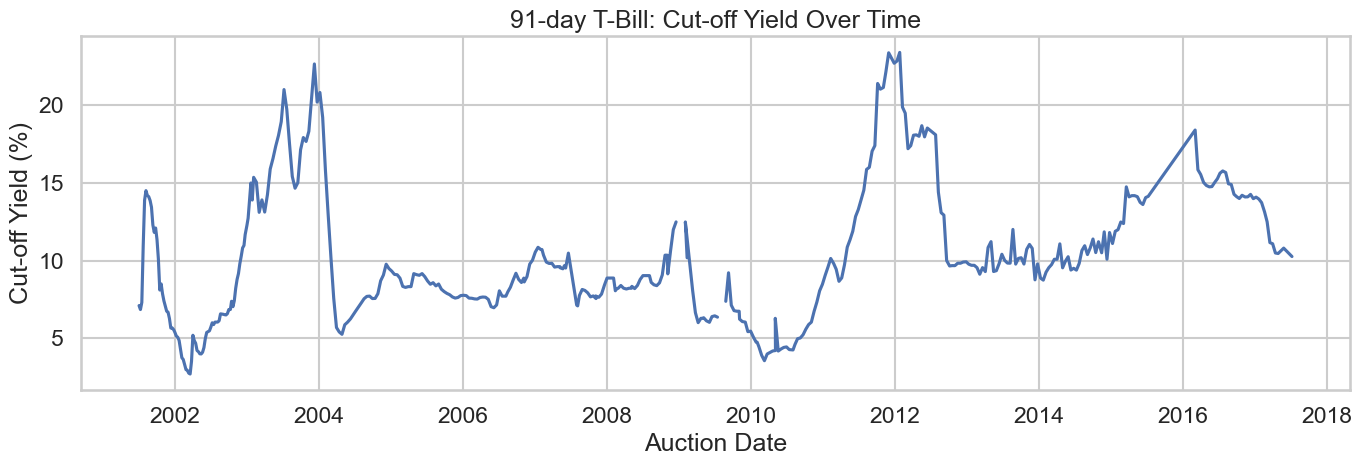

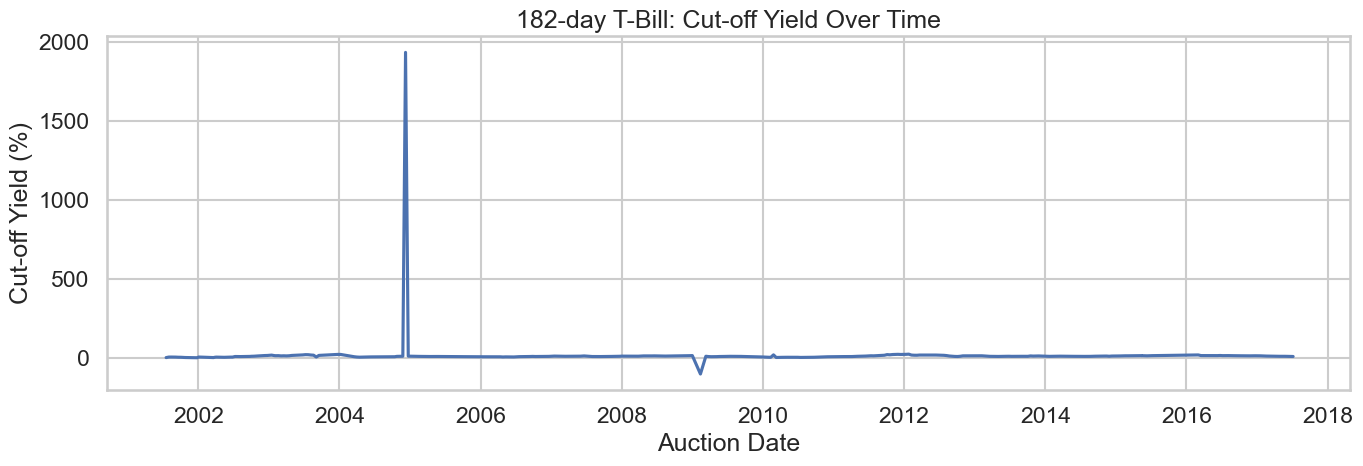

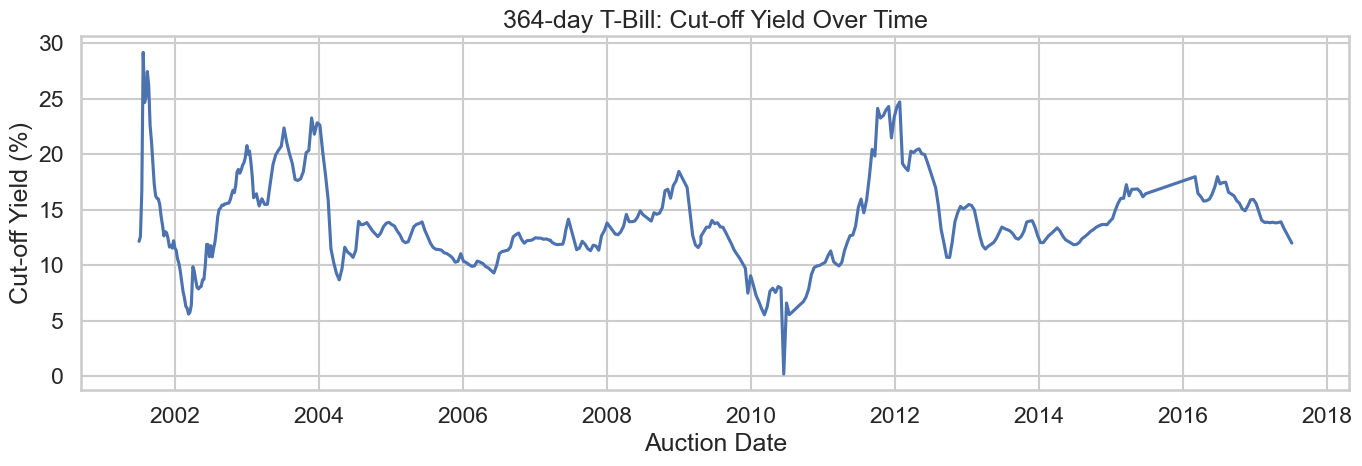

In [18]:
# Quick helper to plot a time series for any tenor
def plot_yield_timeseries(df, tenor_label):
    plt.figure(figsize=(14, 5))
    plt.plot(df["issue_date"], df["cutoff_yield"])
    plt.title(f"{tenor_label} T-Bill: Cut-off Yield Over Time")
    plt.xlabel("Auction Date")
    plt.ylabel("Cut-off Yield (%)")
    plt.tight_layout()
    plt.show()

plot_yield_timeseries(t91_clean,  "91-day")
plot_yield_timeseries(t182_clean, "182-day")
plot_yield_timeseries(t364_clean, "364-day")


**4.2 – Distribution of yields and bid-to-cover (by tenor)**

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


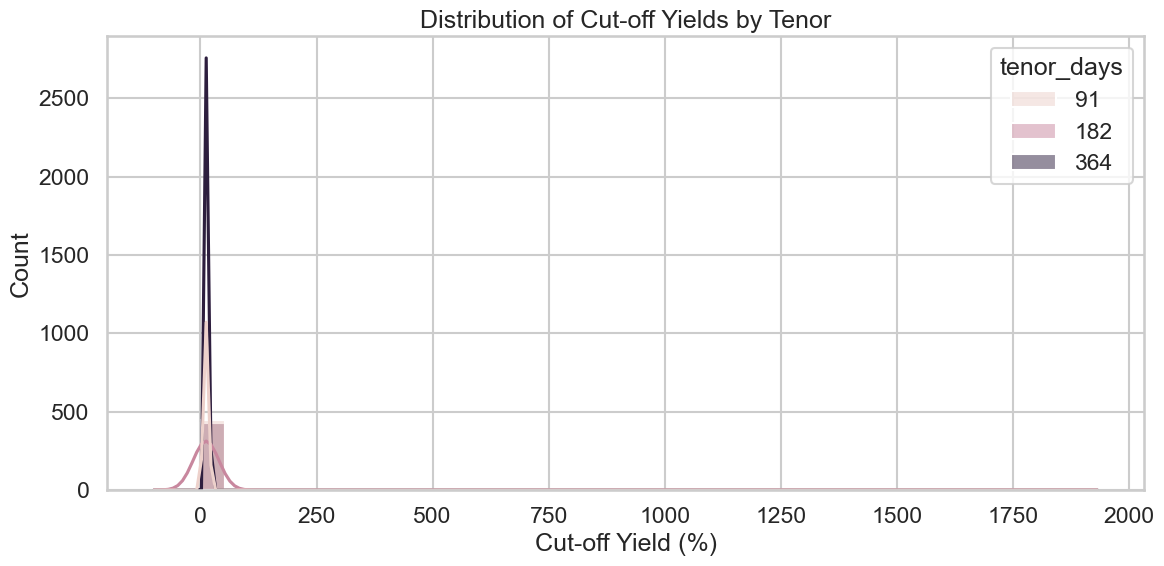

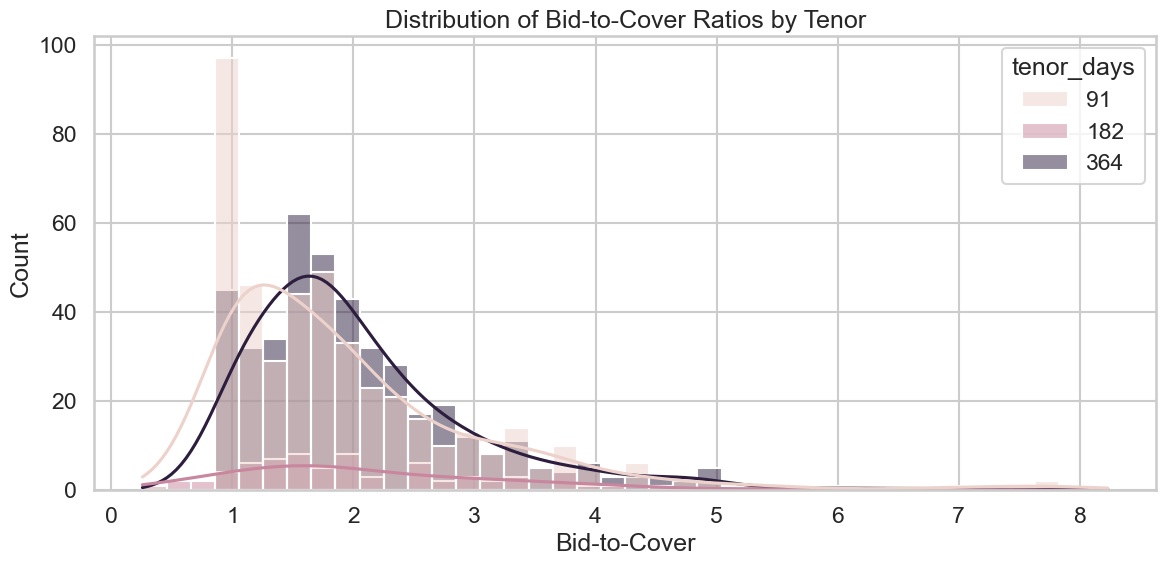

In [29]:
# Add a tenor label temporarily for simple stacked EDA
t91_eda  = t91_clean.assign(tenor_days=91)
t182_eda = t182_clean.assign(tenor_days=182)
t364_eda = t364_clean.assign(tenor_days=364)

eda_all = pd.concat([t91_eda, t182_eda, t364_eda], ignore_index=True)

plt.figure(figsize=(12, 6))
sns.histplot(
    data=eda_all,
    x="cutoff_yield",
    hue="tenor_days",
    kde=True,
    bins=40
)
plt.title("Distribution of Cut-off Yields by Tenor")
plt.xlabel("Cut-off Yield (%)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(
    data=eda_all,
    x="bid_to_cover",
    hue="tenor_days",
    kde=True,
    bins=40
)
plt.title("Distribution of Bid-to-Cover Ratios by Tenor")
plt.xlabel("Bid-to-Cover")
plt.tight_layout()
plt.show()


# Section 5 – Build Unified Auction Panel (Data Engineering)
**This is the base we’ll use for feature engineering and modeling.**

In [31]:
# ====  Unified Auction Panel ====

# Define the modeling columns we care about
auction_cols = [
    "auction_no",
    "issue_date",
    "tenor_days",
    "amount_offered",
    "total_bids",
    "over_under_subscribed",
    "face_value",
    "cost_value",
    "interest_due",
    "duration_days",
    "implicit_annual_yield",
    "cutoff_yield",          # main target
    "lowest_factor_pct",
    "lowest_yield",
    "weighted_avg_price",
    "weighted_avg_yield",
    "average_discount",
    "average_discount_factor",
    "money_market_yield",
    "annualised_yield",
    "rejected_amount",
    "bid_to_cover",
]

def select_auction_cols(df):
    cols_present = [c for c in auction_cols if c in df.columns]
    return df[cols_present].copy()

t91_m  = select_auction_cols(t91_clean)
t182_m = select_auction_cols(t182_clean)
t364_m = select_auction_cols(t364_clean)

# Concatenate all tenors into a long panel
auctions_all = pd.concat([t91_m, t182_m, t364_m], ignore_index=True)

# Drop rows with missing key fields
auctions_all = auctions_all[auctions_all["issue_date"].notna()]
auctions_all = auctions_all[auctions_all["cutoff_yield"].notna()]

# Sort by tenor and date
auctions_all = auctions_all.sort_values(["tenor_days", "issue_date"]).reset_index(drop=True)

# Create a clearly named target (both percent and basis points)
auctions_all["y_cutoff_pct"] = auctions_all["cutoff_yield"]
auctions_all["y_cutoff_bp"]  = auctions_all["cutoff_yield"] * 100  # 10.5% -> 1050bp

auctions_all.head()


,auction_no,issue_date,tenor_days,amount_offered,total_bids,over_under_subscribed,face_value,cost_value,interest_due,duration_days,...,cutoff_yield,lowest_factor_pct,weighted_avg_price,average_discount_factor,money_market_yield,annualised_yield,rejected_amount,bid_to_cover,y_cutoff_pct,y_cutoff_bp
0,469.0,2001-07-04,91,1500000000,2402100000,902100000,1500000000,1473850685,26149315,91.0,...,7.116,4.0,98.257,6.992,<NA>,7.116,<NA>,1.601,7.116,711.6
1,470.0,2001-07-11,91,2000000000,6763900000,4763900000,2000000000,1966357750,33642250,91.0,...,6.862,6.0,98.318,6.747,<NA>,6.862,<NA>,3.382,6.862,686.2
2,471.0,2001-07-18,91,2000000000,3562000000,1562000000,2000000000,1964154360,35845640,91.0,...,7.32,6.746,98.208,7.189,<NA>,7.32,<NA>,1.781,7.32,732.0
3,472.0,2001-07-25,91,3000000000,3034500000,34500000,3000000000,2920291115,79708885,91.0,...,10.948,7.019,97.343,10.657,<NA>,10.948,<NA>,1.012,10.948,1094.8
4,473.0,2001-08-01,91,3000000000,3000000000,<NA>,3000000000,2899532650,100467350,91.0,...,13.898,9.001,96.651,13.432,<NA>,13.898,<NA>,1.0,13.898,1389.8


At this point, we have a single dataset with one row per auction per tenor and a clear target variable.

# Section 6 – Feature Engineering: Lags & Rolling Stats

**6.1 Generated history-based features per tenor (ex-ante information only).**

In [32]:
# ====  Feature Engineering - Lags & Rolling Features ====

def add_lag_features(df, group_col="tenor_days", sort_col="issue_date"):
    """
    Add lagged and rolling-window features per tenor.
    These use only past information (shifted), so they are safe for forecasting.
    """
    df = df.sort_values([group_col, sort_col]).copy()

    # 1-lag features (previous auction of same tenor)
    df["lag1_cutoff"]     = df.groupby(group_col)["cutoff_yield"].shift(1)
    df["lag1_bid_to_cov"] = df.groupby(group_col)["bid_to_cover"].shift(1)
    df["lag1_total_bids"] = df.groupby(group_col)["total_bids"].shift(1)

    # Rolling features for cut-off yield (3 and 5 previous auctions)
    df["roll3_cutoff_mean"] = (
        df.groupby(group_col)["cutoff_yield"]
          .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
    )
    df["roll3_cutoff_std"] = (
        df.groupby(group_col)["cutoff_yield"]
          .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).std())
    )

    df["roll5_cutoff_mean"] = (
        df.groupby(group_col)["cutoff_yield"]
          .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
    )
    df["roll5_cutoff_std"] = (
        df.groupby(group_col)["cutoff_yield"]
          .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).std())
    )

    # Rolling demand pressure via bid-to-cover
    if "bid_to_cover" in df.columns:
        df["roll3_btc_mean"] = (
            df.groupby(group_col)["bid_to_cover"]
              .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
        )
        df["roll3_btc_std"] = (
            df.groupby(group_col)["bid_to_cover"]
              .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).std())
        )

    return df

auctions_fe = add_lag_features(auctions_all)
auctions_fe.head()


,auction_no,issue_date,tenor_days,amount_offered,total_bids,over_under_subscribed,face_value,cost_value,interest_due,duration_days,...,y_cutoff_bp,lag1_cutoff,lag1_bid_to_cov,lag1_total_bids,roll3_cutoff_mean,roll3_cutoff_std,roll5_cutoff_mean,roll5_cutoff_std,roll3_btc_mean,roll3_btc_std
0,469.0,2001-07-04,91,1500000000,2402100000,902100000,1500000000,1473850685,26149315,91.0,...,711.6,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
1,470.0,2001-07-11,91,2000000000,6763900000,4763900000,2000000000,1966357750,33642250,91.0,...,686.2,7.116,1.601,2402100000,7.116000,NaN,7.116000,NaN,1.601000,NaN
2,471.0,2001-07-18,91,2000000000,3562000000,1562000000,2000000000,1964154360,35845640,91.0,...,732.0,6.862,3.382,6763900000,6.989000,0.179605,6.989000,0.179605,2.491500,1.259357
3,472.0,2001-07-25,91,3000000000,3034500000,34500000,3000000000,2920291115,79708885,91.0,...,1094.8,7.32,1.781,3562000000,7.099333,0.229454,7.099333,0.229454,2.254667,0.980439
4,473.0,2001-08-01,91,3000000000,3000000000,<NA>,3000000000,2899532650,100467350,91.0,...,1389.8,10.948,1.012,3034500000,8.376667,2.238584,8.061500,1.933432,2.058333,1.209095


**6.2 – Visualise raw vs rolling yields for one tenor**

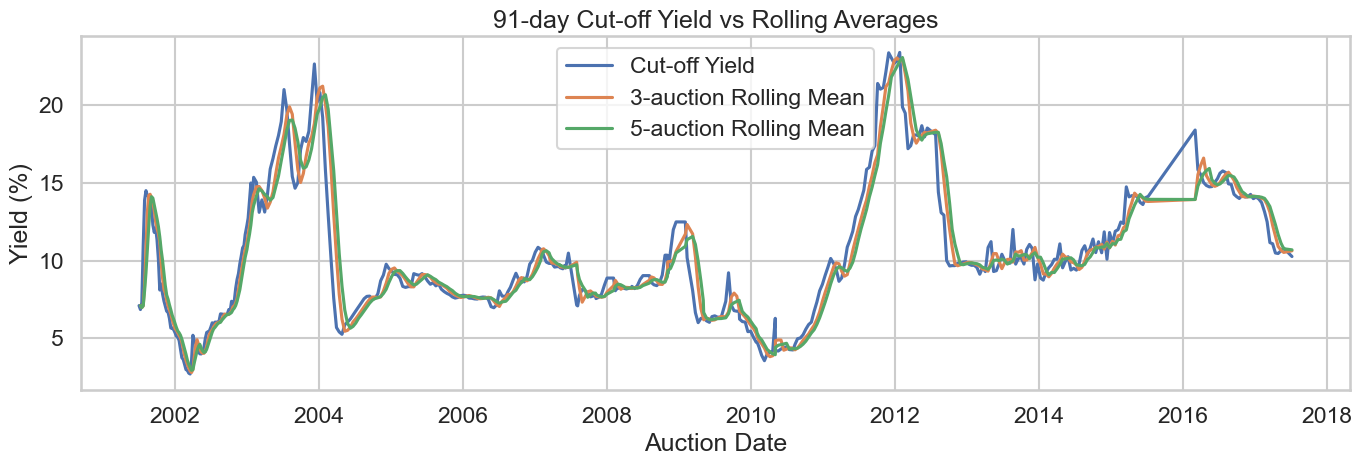

In [22]:
# Example: show the effect of rolling features for 91-day tenor
mask_91 = auctions_fe["tenor_days"] == 91
sub_91 = auctions_fe.loc[mask_91].sort_values("issue_date")

plt.figure(figsize=(14, 5))
plt.plot(sub_91["issue_date"], sub_91["cutoff_yield"], label="Cut-off Yield")
plt.plot(sub_91["issue_date"], sub_91["roll3_cutoff_mean"], label="3-auction Rolling Mean")
plt.plot(sub_91["issue_date"], sub_91["roll5_cutoff_mean"], label="5-auction Rolling Mean")
plt.title("91-day Cut-off Yield vs Rolling Averages")
plt.xlabel("Auction Date")
plt.ylabel("Yield (%)")
plt.legend()
plt.tight_layout()
plt.show()


# Section 7 – Yield Curve Features (Spreads Across Tenors)

**Deriving curve structure: how 91/182/364 relate to each other at each auction date.**

In [35]:
# ==== Section 7: Yield Curve & Spread Features ====

# 1) Start from the engineered auction panel
curve_base = auctions_fe[["issue_date", "tenor_days", "cutoff_yield"]].copy()

# Drop rows with missing key values
curve_base = curve_base.dropna(subset=["issue_date", "tenor_days", "cutoff_yield"])

# Make sure tenor is integer
curve_base["tenor_days"] = curve_base["tenor_days"].astype(int)

# 2) Collapse duplicates: one row per (issue_date, tenor_days)
#    If there are multiple entries on the same date & tenor, we take the mean yield.
curve_base_agg = (
    curve_base
    .groupby(["issue_date", "tenor_days"], as_index=False)["cutoff_yield"]
    .mean()
)

# 3) Pivot to wide format: columns 91, 182, 364
curve_wide = curve_base_agg.pivot(
    index="issue_date",
    columns="tenor_days",
    values="cutoff_yield"
).sort_index()

# (Optional) give clearer column names
curve_wide = curve_wide.rename(columns={
    91:  "y91",
    182: "y182",
    364: "y364",
})

# 4) Add spread columns (will be NaN where a tenor is missing on a date)
curve_wide["spread_364_91"]  = curve_wide["y364"] - curve_wide["y91"]
curve_wide["spread_364_182"] = curve_wide["y364"] - curve_wide["y182"]
curve_wide["spread_182_91"]  = curve_wide["y182"] - curve_wide["y91"]

curve_wide.head()


tenor_days,y91,y182,y364,spread_364_91,spread_364_182,spread_182_91
issue_date,,,,,,
2001-07-04,7.116,3.558,12.147,5.031,8.589,-3.558
2001-07-11,6.862,<NA>,12.573,5.711,<NA>,<NA>
2001-07-18,7.32,3.66,16.693,9.373,13.033,-3.66
2001-07-25,10.948,5.474,29.191,18.243,23.717,-5.474
2001-08-01,13.898,6.949,24.663,10.765,17.714,-6.949



# Section 8 – Calendar / Seasonality Features
Auctions can have seasonal patterns (month-end, quarter-end, fiscal year, etc.). We encode simple calendar features here

In [36]:
# ==== Calendar & Seasonality Features ====

df = auctions_fe.copy()

df["year"]        = df["issue_date"].dt.year
df["month"]       = df["issue_date"].dt.month
df["day_of_week"] = df["issue_date"].dt.weekday  # 0=Mon, 4=Fri etc.
df["quarter"]     = df["issue_date"].dt.quarter

# Auction index per tenor (1st, 2nd, 3rd,... auction in the history of that tenor)
df["auction_index"] = (
    df.sort_values(["tenor_days", "issue_date"])
      .groupby("tenor_days")
      .cumcount() + 1
)

auctions_fe = df
auctions_fe.head()


,auction_no,issue_date,tenor_days,amount_offered,total_bids,over_under_subscribed,face_value,cost_value,interest_due,duration_days,...,roll3_cutoff_std,roll5_cutoff_mean,roll5_cutoff_std,roll3_btc_mean,roll3_btc_std,year,month,day_of_week,quarter,auction_index
0,469.0,2001-07-04,91,1500000000,2402100000,902100000,1500000000,1473850685,26149315,91.0,...,NaN,NaN,NaN,NaN,NaN,2001,7,2,3,1
1,470.0,2001-07-11,91,2000000000,6763900000,4763900000,2000000000,1966357750,33642250,91.0,...,NaN,7.116000,NaN,1.601000,NaN,2001,7,2,3,2
2,471.0,2001-07-18,91,2000000000,3562000000,1562000000,2000000000,1964154360,35845640,91.0,...,0.179605,6.989000,0.179605,2.491500,1.259357,2001,7,2,3,3
3,472.0,2001-07-25,91,3000000000,3034500000,34500000,3000000000,2920291115,79708885,91.0,...,0.229454,7.099333,0.229454,2.254667,0.980439,2001,7,2,3,4
4,473.0,2001-08-01,91,3000000000,3000000000,<NA>,3000000000,2899532650,100467350,91.0,...,2.238584,8.061500,1.933432,2.058333,1.209095,2001,8,2,3,5


**8.1 – Visualise seasonality (example: average yield by month)**

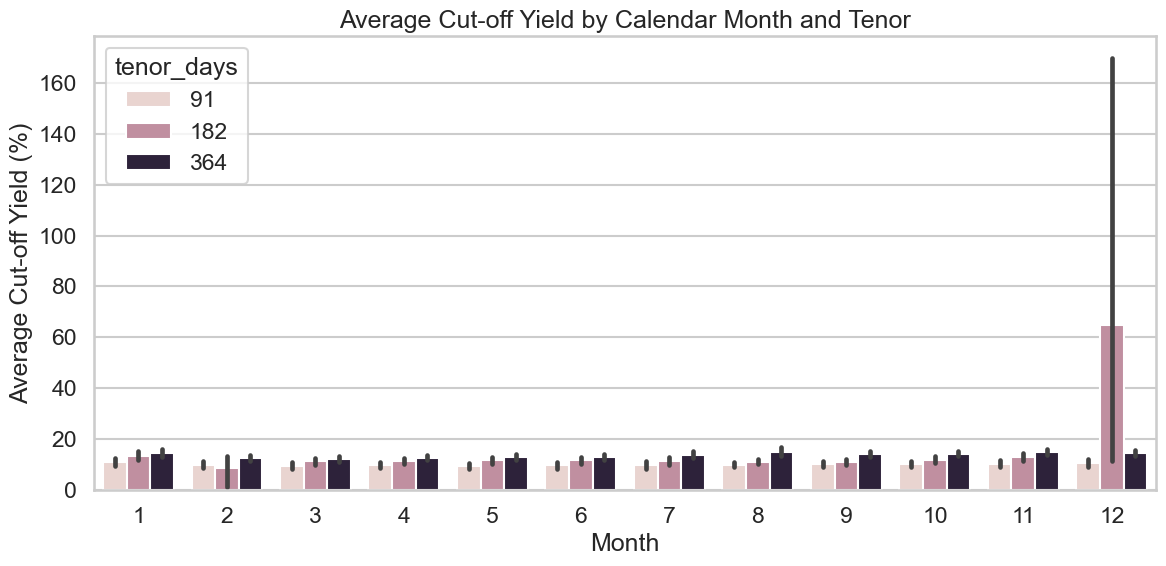

In [51]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=auctions_fe,
    x="month",
    y="cutoff_yield",
    hue="tenor_days",
    estimator="mean"
)
plt.title("Average Cut-off Yield by Calendar Month and Tenor")
plt.xlabel("Month")
plt.ylabel("Average Cut-off Yield (%)")
plt.tight_layout()
plt.show()


#  Section 9 – Secondary Market Features 



### **9a. Parse security into ISIN, type, tenor & maturity**



In [58]:
import re

# ==== 9a: Parse security strings into structured fields ====

def parse_security_row(row):
    """
    Parse the 'security' text into:
      - sec_isin
      - sec_type          ("T-BILL", "T-BOND", or "OTHER")
      - sec_tenor_days    (e.g. 91, 182, 364 for T-bills)
      - sec_maturity_date (datetime)
    Logic branches based on source_label and string patterns.
    """
    s = str(row.get("security", "")).strip()
    src = str(row.get("source_label", "")).lower()

    res = {
        "sec_isin": pd.NA,
        "sec_type": pd.NA,
        "sec_tenor_days": pd.NA,
        "sec_maturity_date": pd.NaT,
    }

    if not s or s.lower() in ["nan", "na", "none"]:
        return pd.Series(res)

    # ---------- CASE 1: Old file (secondary_upto_2022) ----------
    if "upto_2022" in src:
        # Examples:
        #  - "Q000005/T/BOND/2/14/JAN/2006"
        #  - "Q000005-T-BILL-364-15-SEP-2005"
        if "T-BILL" in s:
            res["sec_type"] = "T-BILL"

            # Example: "Q000005-T-BILL-364-15-SEP-2005"
            parts = [p.strip() for p in s.split("-")]

            # ISIN-ish code at the beginning
            if parts:
                res["sec_isin"] = parts[0]

            # Tenor is usually the numeric token (e.g. 364)
            tenor_part = None
            for p in parts:
                if p.isdigit():
                    tenor_part = p
                    break
            if tenor_part is not None:
                res["sec_tenor_days"] = int(tenor_part)

            # Maturity date: usually last 3 chunks: day, month, year
            if len(parts) >= 3:
                date_str = "-".join(parts[-3:])  # "15-SEP-2005"
                res["sec_maturity_date"] = parse_date_col(pd.Series([date_str])).iloc[0]

        elif "T/BOND" in s or "BOND" in s:
            # Example: "Q000005/T/BOND/2/14/JAN/2006"
            res["sec_type"] = "T-BOND"

            # Split by "/" and reconstruct date from the tail
            parts = [p.strip() for p in s.split("/")]
            if parts:
                res["sec_isin"] = parts[0]

            if len(parts) >= 3:
                # Last three items look like "14", "JAN", "2006"
                date_str = "-".join(parts[-3:])
                res["sec_maturity_date"] = parse_date_col(pd.Series([date_str])).iloc[0]

        else:
            res["sec_type"] = "OTHER"

    # ---------- CASE 2: New file (secondary_from_2023) ----------
    elif "from_2023" in src:
        # Examples:
        #  - Bond: "UG12L0805428 17.750% 08-MAY-2042"  (ignore for tbill modeling)
        #  - T-bill: "UG11E2803246 28-MAR-2024 364DAYS"
        #  - T-bill: "UG11C0102249 182DAY 01-FEB-2024"
        tokens = s.replace("%", "").split()

        if not tokens:
            return pd.Series(res)

        # First token is ISIN-like
        res["sec_isin"] = tokens[0]

        # Look for a token with DAY/DAYS (tenor)
        tenor_tok = None
        for t in tokens:
            if "DAY" in t.upper():
                tenor_tok = t
                break

        # Look for something that looks like a date (has "-" and some letters)
        date_tok = None
        for t in tokens:
            if "-" in t and any(ch.isalpha() for ch in t):
                date_tok = t
                break

        if tenor_tok is not None:
            res["sec_type"] = "T-BILL"
            # Extract number part: "364DAYS" -> 364, "182DAY" -> 182
            m = re.search(r"(\d+)", tenor_tok)
            if m:
                res["sec_tenor_days"] = int(m.group(1))

        elif date_tok is not None:
            # If we see a date but no tenor, treat as a bond
            res["sec_type"] = "BOND"

        # Parse maturity date if we identified something date-like
        if date_tok is not None:
            res["sec_maturity_date"] = parse_date_col(pd.Series([date_tok])).iloc[0]

    # ---------- CASE 3: Fallback generic parsing ----------
    else:
        # Try to handle any leftover formats generically
        tokens = s.replace("%", "").split()
        if tokens:
            res["sec_isin"] = tokens[0]

        # Try to find tenor
        tenor_match = re.search(r"(\d+)\s*DAY", s, flags=re.IGNORECASE)
        if tenor_match:
            res["sec_type"] = "T-BILL"
            res["sec_tenor_days"] = int(tenor_match.group(1))

        # Try to find date-like token
        date_tok = None
        for t in tokens:
            if "-" in t and any(ch.isalpha() for ch in t):
                date_tok = t
                break
        if date_tok is not None:
            res["sec_maturity_date"] = parse_date_col(pd.Series([date_tok])).iloc[0]

    return pd.Series(res)


# Apply parser to the full secondary dataset
secondary_all_enriched = secondary_all_clean.copy()

parsed_sec = secondary_all_enriched.apply(parse_security_row, axis=1)
secondary_all_enriched = pd.concat([secondary_all_enriched, parsed_sec], axis=1)

# Compute days to maturity where possible
if "date" in secondary_all_enriched.columns:
    secondary_all_enriched["sec_days_to_maturity"] = (
        secondary_all_enriched["sec_maturity_date"] - secondary_all_enriched["date"]
    ).dt.days

secondary_all_enriched.head()


,date,face_value,agreed_cost,security,SECURITY/,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,sec_isin,sec_type,sec_tenor_days,sec_maturity_date,sec_days_to_maturity
0,2023-01-02,50000000000.0,54000000000.0,UG12J1801248 14.000% 18-JAN-2024,NaN,NaN,NaN,NaN,NaN,UG12J1801248,<NA>,<NA>,2024-01-18,381.0
1,2023-01-02,55400000.0,50007364.0,UG11E2112234 364DAYS 21-DEC-2023,NaN,NaN,NaN,NaN,NaN,UG11E2112234,T-BILL,364,2023-12-21,353.0
2,2023-01-02,10000000000.0,<NA>,UG11E0712233 364DAY 07-DEC-2023,NaN,NaN,NaN,NaN,NaN,UG11E0712233,T-BILL,364,2023-12-07,339.0
3,2023-01-02,20000000000.0,<NA>,UG11E2505239 364DAYS 25-MAY-2023,NaN,NaN,NaN,NaN,NaN,UG11E2505239,T-BILL,364,2023-05-25,143.0
4,2023-01-02,10000000000.0,<NA>,UG11C0806237 182DAY 08-JUN-2023,NaN,NaN,NaN,NaN,NaN,UG11C0806237,T-BILL,182,2023-06-08,157.0


### **9b. Build tenor-specific secondary features (replace old Section 9 aggregation)**

In [61]:
# ==== 9b: Secondary Market Aggregation (T-bills only, tenor-specific) ====

# Start from the enriched secondary data
secondary = secondary_all_enriched.copy()

# Keep only T-bills where we know the tenor in days
secondary_tbills = secondary[
    (secondary["sec_type"] == "T-BILL") &
    (secondary["sec_tenor_days"].notna())
].copy()

# Ensure tenor is integer
secondary_tbills["sec_tenor_days"] = secondary_tbills["sec_tenor_days"].astype(int)

# Basic daily aggregates: per (trade date, tenor)
sec_daily = (
    secondary_tbills
    .groupby(["date", "sec_tenor_days"])
    .agg(
        sec_total_face_value=("face_value", "sum"),
        sec_total_agreed_cost=("agreed_cost", "sum"),
        sec_trade_count=("face_value", "count"),
        # optional: average days-to-maturity traded that day for that tenor
        sec_avg_days_to_maturity=("sec_days_to_maturity", "mean"),
    )
    .reset_index()
    .rename(columns={"sec_tenor_days": "tenor_days"})
)

# 7-day rolling sums as liquidity proxies, per tenor
sec_daily = sec_daily.sort_values(["tenor_days", "date"])

sec_daily["sec_7d_face_value_sum"] = (
    sec_daily
    .groupby("tenor_days")["sec_total_face_value"]
    .transform(lambda x: x.rolling(window=7, min_periods=1).sum())
)
sec_daily["sec_7d_trade_count"] = (
    sec_daily
    .groupby("tenor_days")["sec_trade_count"]
    .transform(lambda x: x.rolling(window=7, min_periods=1).sum())
)

# ---- Merge into the auction feature set ----
# Time-aligned, tenor-aligned (as-of joins)
auctions_fe = auctions_fe.sort_values(["tenor_days", "issue_date"])
sec_daily   = sec_daily.sort_values(["tenor_days", "date"])

auctions_fe = pd.merge_asof(
    auctions_fe,
    sec_daily,
    left_on="issue_date",
    right_on="date",
    by="tenor_days",
    direction="backward"  # last known secondary data on or before auction date
)

# Clean up helper 'date' column from the merge
if "date" in auctions_fe.columns:
    auctions_fe = auctions_fe.drop(columns=["date"])

auctions_fe.head()


ValueError: left keys must be sorted

In [ ]:
**Simple secondary features: daily volume and rolling sums, then later refine to tenor-specific yields if/when we extract that from the security field.**

In [52]:
# ==== Secondary Market Aggregation ====
secondary = secondary_all_clean.copy()

sec_daily = (
    secondary
    .groupby("date")
    .agg(
        sec_total_face_value=("face_value", "sum"),
        sec_total_agreed_cost=("agreed_cost", "sum"),
        sec_trade_count=("face_value", "count"),
    )
    .reset_index()
)

sec_daily = sec_daily.sort_values("date")
sec_daily["sec_7d_face_value_sum"] = sec_daily["sec_total_face_value"].rolling(window=7, min_periods=1).sum()
sec_daily["sec_7d_trade_count"]    = sec_daily["sec_trade_count"].rolling(window=7, min_periods=1).sum()

auctions_fe = auctions_fe.sort_values("issue_date")
sec_daily   = sec_daily.sort_values("date")

auctions_fe = pd.merge_asof(
    auctions_fe,
    sec_daily,
    left_on="issue_date",
    right_on="date",
    direction="backward"
)

auctions_fe = auctions_fe.drop(columns=["date"])
auctions_fe.head()


,auction_no,issue_date,tenor_days,amount_offered,total_bids,over_under_subscribed,face_value,cost_value,interest_due,duration_days,...,sec_total_face_value_y,sec_total_agreed_cost_y,sec_trade_count_y,sec_7d_face_value_sum_y,sec_7d_trade_count_y,sec_total_face_value,sec_total_agreed_cost,sec_trade_count,sec_7d_face_value_sum,sec_7d_trade_count
0,469.0,2001-07-04,91,1500000000,2402100000,902100000,1500000000,1473850685,26149315,91.0,...,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN
1,469.0,2001-07-04,364,5000000000,6412000000,1412000000,5000000000,4459772680,540227320,364.0,...,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN
2,469.0,2001-07-04,182,1500000000,2402100000,902100000,1500000000,1473850685,26149315,91.0,...,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN
3,470.0,2001-07-11,91,2000000000,6763900000,4763900000,2000000000,1966357750,33642250,91.0,...,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN
4,470.0,2001-07-11,364,7000000000,7000000000,<NA>,7000000000,6220102016,779897984,364.0,...,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN


**8.1 – Visualise relation between secondary activity and yields**

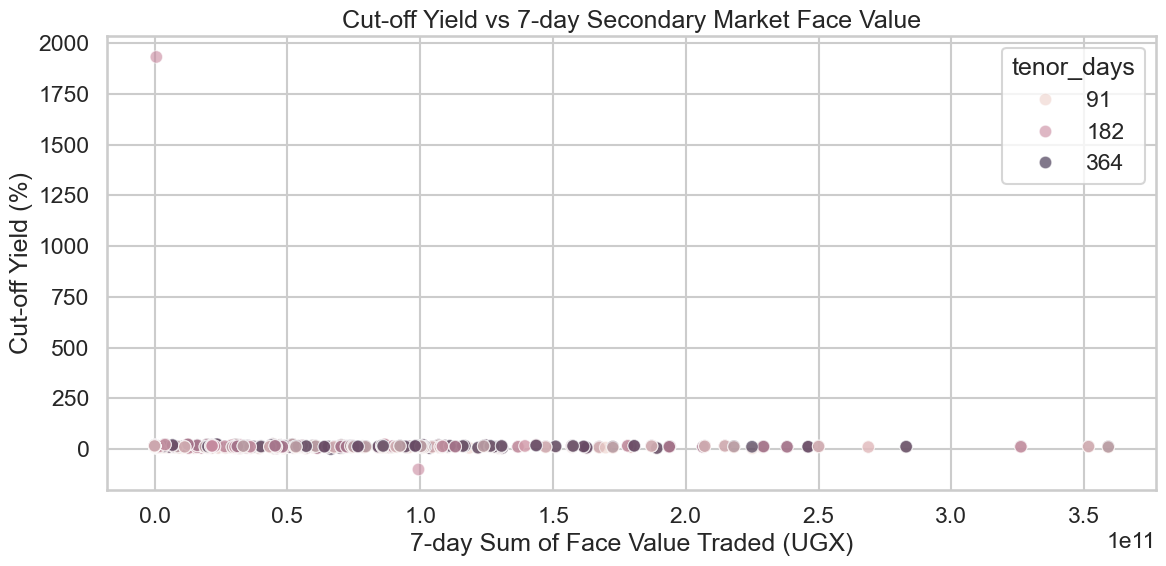

In [53]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=auctions_fe,
    x="sec_7d_face_value_sum",
    y="cutoff_yield",
    hue="tenor_days",
    alpha=0.6
)
plt.title("Cut-off Yield vs 7-day Secondary Market Face Value")
plt.xlabel("7-day Sum of Face Value Traded (UGX)")
plt.ylabel("Cut-off Yield (%)")
plt.tight_layout()
plt.show()


In [54]:
print(secondary_all_clean.columns)


Index(['date', 'face_value', 'agreed_cost', 'security', 'SECURITY/',
       'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7'],
      dtype='object')


# Section 9 – Modeling Setup

In [55]:
# ==== Prepare Modelling Dataset ====

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.base import clone
import numpy as np

# Ensure we have a consistent target column
if "y_cutoff_pct" not in auctions_fe.columns:
    auctions_fe["y_cutoff_pct"] = auctions_fe["cutoff_yield"]

# --- Define a desired feature list (some may not exist yet) ---

desired_feature_cols = [
    "amount_offered",
    "total_bids",
    "bid_to_cover",
    "lag1_cutoff",
    "lag2_cutoff",
    "lag3_cutoff",
    "roll3_cutoff",
    "roll5_cutoff",
    "roll3_btc_mean",
    "roll3_btc_std",
    "month",
    "quarter",
    "day_of_week",
    "auction_index",
]

# Keep only those that actually exist in auctions_fe
feature_cols = [c for c in desired_feature_cols if c in auctions_fe.columns]

# Optional: tell us which ones are missing (useful for debugging / presentation)
missing_features = [c for c in desired_feature_cols if c not in auctions_fe.columns]

print("Using the following features for modelling:")
for c in feature_cols:
    print("  -", c)

if missing_features:
    print("\nThe following requested features are NOT present in auctions_fe and will be skipped:")
    for c in missing_features:
        print("  -", c)

# Drop rows where we are missing the target or any of the chosen features
model_df = auctions_fe.dropna(
    subset=feature_cols + ["y_cutoff_pct", "tenor_days", "issue_date"]
).copy()

# Sort for time-series use
model_df = model_df.sort_values(["tenor_days", "issue_date"]).reset_index(drop=True)

print("\nObservations per tenor in modelling dataset:")
print(model_df["tenor_days"].value_counts())

model_df.head()


Using the following features for modelling:
  - amount_offered
  - total_bids
  - bid_to_cover
  - lag1_cutoff
  - roll3_btc_mean
  - roll3_btc_std
  - month
  - quarter
  - day_of_week
  - auction_index

The following requested features are NOT present in auctions_fe and will be skipped:
  - lag2_cutoff
  - lag3_cutoff
  - roll3_cutoff
  - roll5_cutoff

Observations per tenor in modelling dataset:
tenor_days
91     445
364    430
182     69
Name: count, dtype: int64


,auction_no,issue_date,tenor_days,amount_offered,total_bids,over_under_subscribed,face_value,cost_value,interest_due,duration_days,...,sec_total_face_value_y,sec_total_agreed_cost_y,sec_trade_count_y,sec_7d_face_value_sum_y,sec_7d_trade_count_y,sec_total_face_value,sec_total_agreed_cost,sec_trade_count,sec_7d_face_value_sum,sec_7d_trade_count
0,471.0,2001-07-18,91,2000000000,3562000000,1562000000,2000000000,1964154360,35845640,91.0,...,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN
1,472.0,2001-07-25,91,3000000000,3034500000,34500000,3000000000,2920291115,79708885,91.0,...,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN
2,473.0,2001-08-01,91,3000000000,3000000000,<NA>,3000000000,2899532650,100467350,91.0,...,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN
3,474.0,2001-08-08,91,3000000000,4969200000,1969200000,3000000000,2895219779,104780221,91.0,...,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN
4,475.0,2001-08-15,91,3000000000,8552600000,5552600000,3000000000,2897370000,102630000,91.0,...,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN


# Section 10 – Helper Metrics & Backtesting Function

**Expanding-window backtest per tenor and compare models.**

In [56]:
# ==== Backtesting Setup (Multiple Models per Tenor) ====

def directional_accuracy(y_true, y_pred):
    """
    Percentage of times the model correctly predicts the direction
    of change (up / down) between consecutive auctions.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if len(y_true) < 2:
        return np.nan

    direction_true = np.sign(np.diff(y_true))
    direction_pred = np.sign(np.diff(y_pred))
    return (direction_true == direction_pred).mean() * 100.0


def backtest_tenor_models(df, tenor, feature_cols, model_specs, min_train_size=40):
    """
    Expanding-window backtest for a single tenor, evaluating several models.

    df:          full modelling dataframe (all tenors)
    tenor:       91 / 182 / 364
    feature_cols: list of feature column names
    model_specs: dict {model_name: sklearn_estimator_or_None}
                  - if model_name == "Baseline_lag1", we use lag1_cutoff directly
    min_train_size: minimum number of observations to start training
    """
    df_t = df[df["tenor_days"] == tenor].sort_values("issue_date").copy()

    if df_t.shape[0] <= min_train_size + 2:
        print(f"Not enough observations for tenor {tenor} to backtest. Skipping.")
        return None, None

    # ensure lag1_cutoff exists if baseline is requested
    has_baseline = "Baseline_lag1" in model_specs
    if has_baseline and "lag1_cutoff" not in feature_cols and "lag1_cutoff" not in df_t.columns:
        print(f"Warning: 'Baseline_lag1' requested but 'lag1_cutoff' not available for tenor {tenor}.")
        has_baseline = False

    X_all = df_t[feature_cols]
    y_all = df_t["y_cutoff_pct"]
    dates = df_t["issue_date"].values

    # Store predictions per model
    preds_per_model = {name: [] for name in model_specs.keys()}
    actuals = []
    pred_dates = []

    # Expanding window: grow training set one auction at a time
    for i in range(min_train_size, len(df_t)):
        X_train = X_all.iloc[:i]
        y_train = y_all.iloc[:i]
        X_test  = X_all.iloc[[i]]
        y_test  = y_all.iloc[i]

        # Fit each non-baseline model and generate predictions
        for name, model in model_specs.items():
            if name == "Baseline_lag1":
                # Baseline: predict using lag1_cutoff (previous auction's yield)
                if has_baseline:
                    pred = df_t["lag1_cutoff"].iloc[i]
                    preds_per_model[name].append(pred)
                else:
                    preds_per_model[name].append(np.nan)
                continue

            # For sklearn models: clone and fit fresh each step
            est = clone(model)
            est.fit(X_train, y_train)
            pred = est.predict(X_test)[0]
            preds_per_model[name].append(pred)

        actuals.append(y_test)
        pred_dates.append(dates[i])

    # Build results: metrics per model
    results_rows = []
    for name, preds in preds_per_model.items():
        preds_arr = np.array(preds, dtype=float)
        actuals_arr = np.array(actuals, dtype=float)

        # may contain NaNs if some model was effectively skipped
        mask = ~np.isnan(preds_arr)
        if mask.sum() < 2:
            mae = rmse = da = np.nan
        else:
            mae  = mean_absolute_error(actuals_arr[mask], preds_arr[mask])
            rmse = mean_squared_error(actuals_arr[mask], preds_arr[mask], squared=False)
            da   = directional_accuracy(actuals_arr[mask], preds_arr[mask])

        results_rows.append({
            "model": name,
            "tenor_days": tenor,
            "n_points": mask.sum(),
            "MAE_pct": mae,
            "RMSE_pct": rmse,
            "Directional_Accuracy_%": da,
        })

    results_df = pd.DataFrame(results_rows).sort_values("MAE_pct")

    # Collect prediction trajectories for plotting later
    preds_df = pd.DataFrame({"date": pred_dates, "actual": actuals})
    for name, preds in preds_per_model.items():
        preds_df[name] = preds

    return results_df, preds_df


# Section 11 – Define Models & Run Backtests per Tenor

***. Defining several models including :***
- Baseline_lag1 (previous auction yield)

- Ridge

- Lasso

- RandomForest

- GradientBoosting

In [57]:
# ==== Section 11: Run Backtests for Multiple Models per Tenor ====

# Define the models we want to compare
model_specs = {
    "Baseline_lag1": None,  # simple benchmark: last auction's yield

    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    ),

    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ),
}


# Run backtests per tenor
backtest_results = {}
predictions_store = {}

for tenor in [91, 182, 364]:
    print(f"\n=== Backtesting models for tenor {tenor}-day ===")
    res_df, preds_df = backtest_tenor_models(model_df, tenor, feature_cols, model_specs, min_train_size=40)
    if res_df is not None:
        backtest_results[tenor] = res_df
        predictions_store[tenor] = preds_df
        display(res_df)
    else:
        backtest_results[tenor] = None
        predictions_store[tenor] = None



=== Backtesting models for tenor 91-day ===


TypeError: got an unexpected keyword argument 'squared'

# Section 12 – Plot Actual vs Predicted for Best Model

Picking the model with lowest MAE for each tenor and plot that.

In [ ]:
print("===== CHECKPOINT =====")

# 1. Does auctions_fe exist?
try:
    print("auctions_fe exists. Shape:", auctions_fe.shape)
except Exception as e:
    print("auctions_fe does NOT exist:", e)

# 2. Print all variables currently defined
print("\nVariables in memory:")
print([x for x in dir() if not x.startswith("_")])

# 3. Quick check if notebook is actually executing
print("\nNotebook execution OK if you see this line.")


In [ ]:
print("tenor_days column exists:", "tenor_days" in auctions_fe.columns)

if "tenor_days" in auctions_fe.columns:
    print(auctions_fe["tenor_days"].value_counts())


In [ ]:
print("===== STARTING SIMPLE 91-DAY MODEL TEST =====")

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

%matplotlib inline

# 1) Filter to 91-day auctions
df91 = auctions_fe[auctions_fe["tenor_days"] == 91].copy()
print("Rows in df91:", df91.shape)

# 2) Minimal feature list (must exist)
candidate_features = [
    "amount_offered",
    "total_bids",
    "bid_to_cover",
    "cutoff_yield",      # target
    "month",
    "quarter",
    "day_of_week",
    "auction_index",
]

# Check which actually exist
feature_cols = [c for c in candidate_features if c in df91.columns]

print("\nFeature columns FOUND in df91:")
print(feature_cols)

# 3) Drop missing
df91_clean = df91.dropna(subset=feature_cols).copy()
df91_clean = df91_clean.sort_values("issue_date").reset_index(drop=True)

print("\nRows after cleaning:", df91_clean.shape)

# 4) Build X and y
X = df91_clean[feature_cols].drop(columns=["cutoff_yield"])
y = df91_clean["cutoff_yield"]

print("\nShapes:")
print("X:", X.shape, "y:", y.shape)

# 5) Train/test split (80/20 time split)
split_index = int(len(df91_clean) * 0.8)
X_train, y_train = X[:split_index], y[:split_index]
X_test,  y_test  = X[split_index:], y[split_index:]
dates_test = df91_clean["issue_date"].iloc[split_index:]

print("\nTrain size:", len(X_train), "Test size:", len(X_test))

# 6) Train model
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    random_state=42
)
model.fit(X_train, y_train)

# 7) Predict
y_pred = model.predict(X_test)

# 8) Evaluate
mae = mean_absolute_error(y_test, y_pred)
print("\n91-day RandomForest MAE:", mae)

# 9) Plot
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test.values, label="Actual", linewidth=2)
plt.plot(dates_test, y_pred, label="Predicted", linestyle="--")
plt.title("91-day T-Bill: Actual vs Predicted Cut-off Yield")
plt.xlabel("Auction Date")
plt.ylabel("Cut-off Yield (%)")
plt.legend()
plt.tight_layout()
plt.show()




# Section 13 – Compare Multiple Models (91-day only)

In [ ]:
# ==== Compare Several Models on 91-day T-bill (Simple Train/Test) ====

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline

print("=== Rebuilding 91-day clean dataset (for safety) ===")

# 1) Filter to 91-day auctions
df91 = auctions_fe[auctions_fe["tenor_days"] == 91].copy()

# 2) Use the same simple, reliable feature set
candidate_features = [
    "amount_offered",
    "total_bids",
    "bid_to_cover",
    "cutoff_yield",      # target
    "month",
    "quarter",
    "day_of_week",
    "auction_index",
]

# Keep only those that actually exist
feature_cols = [c for c in candidate_features if c in df91.columns]

print("Feature columns FOUND in df91:")
for c in feature_cols:
    print("  -", c)

# 3) Drop rows with missing values in features or issue_date
df91_clean = df91.dropna(subset=feature_cols + ["issue_date"]).copy()
df91_clean = df91_clean.sort_values("issue_date").reset_index(drop=True)

print("\nRows after cleaning:", df91_clean.shape)

# 4) Build X and y
X = df91_clean[feature_cols].drop(columns=["cutoff_yield"])
y = df91_clean["cutoff_yield"]

# 5) Time-based 80/20 split
split_idx = int(len(df91_clean) * 0.8)
X_train, y_train = X.iloc[:split_idx], y.iloc[:split_idx]
X_test,  y_test  = X.iloc[split_idx:],  y.iloc[split_idx:]
dates_test = df91_clean["issue_date"].iloc[split_idx:]

print("Train size:", len(X_train), "Test size:", len(X_test))

# 6) Define models to compare
models = {
    # Very simple baseline: always predict the mean of the training cutoff_yield
    "Baseline_Mean": "baseline_mean",

    # Linear model with scaling
    "Ridge": make_pipeline(
        StandardScaler(),
        Ridge(alpha=10.0)
    ),

    # Tree-based models
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    ),

    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ),
}

results = []
predictions = {}

# 7) Train, predict, and evaluate each model
for name, model in models.items():
    print(f"\n--- Training model: {name} ---")
    
    if model == "baseline_mean":
        # Simple baseline prediction
        y_pred = np.full_like(y_test, y_train.mean(), dtype=float)
    else:
        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    predictions[name] = y_pred
    
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # compatible with older sklearn
    
    results.append({
        "model": name,
        "MAE_pct": mae,
        "RMSE_pct": rmse
    })

# 8) Show comparison table
results_df = pd.DataFrame(results).sort_values("MAE_pct").reset_index(drop=True)
print("\n=== 91-day Model Performance (Test Set) ===")
display(results_df)

# 9) Plot Actual vs Best Model
best_model_name = results_df.iloc[0]["model"]
print(f"\nBest model on test set: {best_model_name}")

plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test.values, label="Actual", linewidth=2)
plt.plot(dates_test, predictions[best_model_name],
         label=f"Predicted ({best_model_name})", linestyle="--", linewidth=2)
plt.title("91-day T-Bill: Actual vs Predicted Cut-off Yield (Best Model)")
plt.xlabel("Auction Date")
plt.ylabel("Cut-off Yield (%)")
plt.legend()
plt.tight_layout()
plt.show()


**Above code shows the following for t91 Tbills** 

    - * A table ranking the models by MAE
    - * A print like: Best model on test set: RandomForest (or another)
    - * A plot showing actual vs predicted 91-day cut-off yields over the test period.

**Result Interpretation** 

**1. Ridge regression is performing the best**
        #- Even though tree models are more flexible, Ridge won because:

            #- The baseline features are simple
            #- There are no lag or roll features yet
            #- Ridge handles linear relationships well
            #- It benefits from feature scaling (we used StandardScaler)

            #- Note: data has strong linear trends between auction features and cutoff yield.

**2. Tree models will improve when we give more structure**
    
        RandomForest and GradientBoosting usually beat linear models, but only when they have:
        
            #- Lag features (lag1, lag2, lag3)
            #- Rolling features (roll3, roll5)
            #- Spread features (yield curve structure)
            #- Secondary market features
            #- Seasonal/cycle indicators
            #- Right now they’re underpowered.

**3. Baseline is the worst**

            #- Predicting a constant value (average yield) is crude.



# Section 14 — Add Lag & Rolling Features (All Tenors)

In [ ]:
# ==== Section 12: Add Lag & Rolling Features (All Tenors) ====

import numpy as np
import pandas as pd

# Just in case: ensure calendar features exist
if "month" not in auctions_fe.columns:
    auctions_fe["month"] = auctions_fe["issue_date"].dt.month
if "quarter" not in auctions_fe.columns:
    auctions_fe["quarter"] = auctions_fe["issue_date"].dt.quarter
if "day_of_week" not in auctions_fe.columns:
    auctions_fe["day_of_week"] = auctions_fe["issue_date"].dt.dayofweek
if "auction_index" not in auctions_fe.columns:
    auctions_fe = auctions_fe.sort_values("issue_date")
    auctions_fe["auction_index"] = auctions_fe.groupby("tenor_days").cumcount()

def add_lags_and_rolls(df):
    """
    For each tenor (91, 182, 364), add:
      - lag1/lag2/lag3 of cutoff_yield
      - lag1/lag2 of bid_to_cover
      - rolling means/stds of cutoff_yield
      - rolling means/stds of bid_to_cover
    """
    df = df.sort_values(["tenor_days", "issue_date"]).copy()

    def enrich(group):
        group = group.sort_values("issue_date").copy()

        # Lags of cutoff
        for k in [1, 2, 3]:
            group[f"lag{k}_cutoff"] = group["cutoff_yield"].shift(k)

        # Lags of bid-to-cover
        group["lag1_btc"] = group["bid_to_cover"].shift(1)
        group["lag2_btc"] = group["bid_to_cover"].shift(2)

        # Rolling stats (use shifted values so we only use past info)
        group["roll3_cutoff_mean"] = (
            group["cutoff_yield"].shift(1).rolling(window=3, min_periods=1).mean()
        )
        group["roll5_cutoff_mean"] = (
            group["cutoff_yield"].shift(1).rolling(window=5, min_periods=1).mean()
        )
        group["roll3_cutoff_std"] = (
            group["cutoff_yield"].shift(1).rolling(window=3, min_periods=1).std()
        )

        group["roll3_btc_mean"] = (
            group["bid_to_cover"].shift(1).rolling(window=3, min_periods=1).mean()
        )
        group["roll3_btc_std"] = (
            group["bid_to_cover"].shift(1).rolling(window=3, min_periods=1).std()
        )

        return group

    return df.groupby("tenor_days", group_keys=False).apply(enrich)

auctions_fe_adv = add_lags_and_rolls(auctions_fe)

print("Shape with advanced features:", auctions_fe_adv.shape)
print("\nNew time-series feature columns exist?")
for c in [
    "lag1_cutoff","lag2_cutoff","lag3_cutoff",
    "lag1_btc","lag2_btc",
    "roll3_cutoff_mean","roll5_cutoff_mean","roll3_cutoff_std",
    "roll3_btc_mean","roll3_btc_std"
]:
    print(f"  {c}: {c in auctions_fe_adv.columns}")


# Section 15 — Build Modeling Dataset with Advanced Features

In [ ]:
# ==== Build Modelling Dataset (All Tenors, Advanced Features) ====

# Target
target_col = "cutoff_yield"

# Candidate features to use in models
candidate_features = [
    # Auction demand/supply
    "amount_offered",
    "total_bids",
    "bid_to_cover",

    # Lags of yield
    "lag1_cutoff",
    "lag2_cutoff",
    "lag3_cutoff",

    # Lags of demand
    "lag1_btc",
    "lag2_btc",

    # Rolling yield stats
    "roll3_cutoff_mean",
    "roll5_cutoff_mean",
    "roll3_cutoff_std",

    # Rolling bid-to-cover stats
    "roll3_btc_mean",
    "roll3_btc_std",

    # Calendar / cycle
    "month",
    "quarter",
    "day_of_week",
    "auction_index",
]

# Keep only those that actually exist
feature_cols = [c for c in candidate_features if c in auctions_fe_adv.columns]
missing_cols = [c for c in candidate_features if c not in auctions_fe_adv.columns]

print("Using these feature columns:")
for c in feature_cols:
    print("  -", c)

if missing_cols:
    print("\nThese requested features are missing and will be skipped:")
    for c in missing_cols:
        print("  -", c)

# Drop rows where any chosen feature or target/keys are missing
model_df = auctions_fe_adv.dropna(
    subset=feature_cols + [target_col, "tenor_days", "issue_date"]
).copy()

# Sort by tenor then date
model_df = model_df.sort_values(["tenor_days", "issue_date"]).reset_index(drop=True)

print("\nModelling dataframe shape:", model_df.shape)
print("\nObservations per tenor in modelling dataset:")
print(model_df["tenor_days"].value_counts())
model_df.head()


# Section 16 — Define Expanding-Window Backtest Function

In [ ]:
# ==== Section 14: Expanding-Window Backtest per Tenor ====

from sklearn.base import clone
from sklearn.metrics import mean_absolute_error, mean_squared_error

def backtest_tenor_models(df, tenor, feature_cols, model_specs, min_train_size=60):
    """
    Expanding-window backtest for one tenor (91/182/364).
    - df: modelling dataframe (all tenors)
    - tenor: e.g. 91
    - feature_cols: list of feature names
    - model_specs: dict {model_name: estimator or None for baseline}
    - min_train_size: number of initial observations for training
    """
    df_t = df[df["tenor_days"] == tenor].sort_values("issue_date").copy()
    n = len(df_t)
    print(f"\nTenor {tenor}: {n} rows in modelling dataset")

    if n <= min_train_size + 5:
        print(f"⚠️ Not enough data for tenor {tenor} (need > {min_train_size + 5}). Skipping.")
        return None, None

    X_all = df_t[feature_cols]
    y_all = df_t[target_col]
    dates = df_t["issue_date"].values

    preds_per_model = {name: [] for name in model_specs.keys()}
    actuals = []
    pred_dates = []

    for i in range(min_train_size, n):
        X_train = X_all.iloc[:i]
        y_train = y_all.iloc[:i]
        X_test  = X_all.iloc[[i]]
        y_test  = y_all.iloc[i]

        for name, model in model_specs.items():
            if name == "Baseline_lag1":
                # Use lag1_cutoff as naive forecast if available
                if "lag1_cutoff" in df_t.columns:
                    pred = df_t["lag1_cutoff"].iloc[i]
                else:
                    pred = np.nan
            else:
                est = clone(model)
                est.fit(X_train, y_train)
                pred = est.predict(X_test)[0]

            preds_per_model[name].append(pred)

        actuals.append(y_test)
        pred_dates.append(dates[i])

    # Compute metrics
    results_rows = []
    for name, preds in preds_per_model.items():
        preds_arr  = np.array(preds, dtype=float)
        actual_arr = np.array(actuals, dtype=float)
        mask = ~np.isnan(preds_arr)

        if mask.sum() < 2:
            mae = rmse = np.nan
        else:
            mae  = mean_absolute_error(actual_arr[mask], preds_arr[mask])
            rmse = np.sqrt(mean_squared_error(actual_arr[mask], preds_arr[mask]))

        results_rows.append({
            "model": name,
            "tenor_days": tenor,
            "n_points": mask.sum(),
            "MAE_pct": mae,
            "RMSE_pct": rmse,
        })

    results_df = pd.DataFrame(results_rows).sort_values("MAE_pct")

    preds_df = pd.DataFrame({"date": pred_dates, "actual": actuals})
    for name, preds in preds_per_model.items():
        preds_df[name] = preds

    return results_df, preds_df


# Section 17 — Define Models and Run Backtests for All Tenors

In [ ]:
# ====  Run Backtests for 91, 182, 364 ====

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Define models
model_specs = {
    "Baseline_lag1": None,

    "Ridge": make_pipeline(
        StandardScaler(),
        Ridge(alpha=10.0)
    ),

    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    ),

    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ),
}

backtest_results = {}
predictions_store = {}

for tenor in [91, 182, 364]:
    res_df, preds_df = backtest_tenor_models(
        model_df,
        tenor,
        feature_cols,
        model_specs,
        min_train_size=60
    )
    backtest_results[tenor] = res_df
    predictions_store[tenor] = preds_df

    if res_df is not None:
        print(f"\n=== Backtest results for {tenor}-day tenor ===")
        display(res_df)
    else:
        print(f"\n⚠️ No backtest results for tenor {tenor}.")


# Section 18 — Plot Actual vs Predicted for Best Model per Tenor

In [ ]:
# ==== Section 16: Plot Actual vs Predicted for Best Model per Tenor ====

import matplotlib.pyplot as plt
%matplotlib inline

def plot_best_model_for_tenor(tenor, results_dict, preds_dict):
    res_df = results_dict.get(tenor)
    preds_df = preds_dict.get(tenor)

    if res_df is None or preds_df is None:
        print(f"No results available for tenor {tenor}.")
        return

    if len(preds_df) == 0:
        print(f"Predictions dataframe empty for tenor {tenor}.")
        return

    # choose best model by lowest MAE
    best_row = res_df.sort_values("MAE_pct").iloc[0]
    best_model_name = best_row["model"]
    print(f"\nBest model for {tenor}-day tenor: {best_model_name}")
    display(best_row.to_frame().T)

    plt.figure(figsize=(14, 6))
    plt.plot(preds_df["date"], preds_df["actual"], label="Actual", linewidth=2)
    plt.plot(preds_df["date"], preds_df[best_model_name],
             label=f"Predicted ({best_model_name})", linestyle="--", linewidth=2)
    plt.title(f"{tenor}-day T-Bill: Actual vs Predicted Cut-off Yield (Backtest)")
    plt.xlabel("Auction Date")
    plt.ylabel("Cut-off Yield (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot for all three tenors
for t in [91, 182, 364]:
    plot_best_model_for_tenor(t, backtest_results, predictions_store)


In [ ]:
for tenor in [182, 364]:
    print(f"\n=== Missing Ratios for {tenor}-day ===")
    df_t = auctions_fe_adv[auctions_fe_adv["tenor_days"] == tenor]
    display(df_t.isna().mean().sort_values(ascending=False).to_frame("missing_ratio"))
